# Load Libraries

In [ ]:
import os 
import pandas as pd
import numpy as np 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import gc 
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.exceptions import UndefinedMetricWarning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
%matplotlib inline
#Setting plot sizes and type of plot
plt.rc("font", size=14)
plt.rcParams['axes.grid'] = True
plt.figure(figsize=(6,3))
plt.gray()

import dill as pickle 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, average_precision_score, PrecisionRecallDisplay, ConfusionMatrixDisplay, classification_report

<Figure size 432x216 with 0 Axes>

# Load data

In [ ]:
# Remove this code 
import os 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading data
train_df = pd.read_pickle('train_df')
test_df = pd.read_pickle('test_df')

train_df.reset_index(drop = True,inplace = True)
test_df.reset_index(drop = True,inplace = True)

In [ ]:
#weight scaling for pos label (to be used later in optuna)
scale_pos_weight = len(train_df[train_df.isFraud == False])/len(train_df[train_df.isFraud == True])

 Split train dataset into input (X i.e. train) and output (y ie. train_labels)

In [ ]:
train = train_df.drop("isFraud", axis=1)
train_labels = train_df["isFraud"].copy()

In [ ]:
def dtype_sep(df):
  """
  Function returns seperate list of columns of dataframe based on datatype

  Parameter and type: 
    df(Pandas Dataframe): Dataframe

  Return:
    :rtype: Tuple
    :return: Tuple of lists, where each list has the column names of same dtype
  """
  num_cols = []
  obj_cols = []
  date_cols = []
  bool_cols = []
  category_cols = []

  for col in df:
    if df[col].dtype in ['int8','int32','int64','float16','float32','float64']:
      num_cols.append(col)

    elif df[col].dtype in ('object','bool','category'):
      obj_cols.append(col)

    elif df[col].dtype == 'datetime64[ns]':
      date_cols.append(col)

  return (num_cols,obj_cols,date_cols)

In [ ]:
num_cols,obj_cols,date_cols = dtype_sep(train)  

### Prepare Train Data

In [ ]:
cols_to_drop = ['accountNumber','customerId','cardCVV','enteredCVV','cardLast4Digits',
                'transactionDateTime','currentExpDate','accountOpenDate','dateOfLastAddressChange']       

In [ ]:
#prepare new features and delete features no longer needed

def add_features(df):
  df = df.copy()
  df["txn_year"] = df['transactionDateTime'].dt.year
  df["txn_month"] = df['transactionDateTime'].dt.month
  df["txn_dayofmonth"] = df['transactionDateTime'].dt.day
  df["txn_dayofweek"] = df['transactionDateTime'].dt.dayofweek
  df["txn_dayofyear"] = df['transactionDateTime'].dt.dayofyear
  df["txn_quarter"] = df['transactionDateTime'].dt.quarter
  df["txn_hour"] = df['transactionDateTime'].dt.hour
  df["txn_weekofyear"] = df['transactionDateTime'].dt.isocalendar().week.astype('int64')
  df['cvv_match'] = (df['cardCVV'] == df['enteredCVV']).astype('bool')
  df['card_age'] = (df['currentExpDate'] - df['accountOpenDate']).dt.days
  df['account_age'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days
  df['merchantName'] = df.merchantName.str.split('#').str[0].str.strip()
  df.drop(cols_to_drop,axis = 'columns',inplace = True)

  return df


In [ ]:
train_prepared = add_features(train)
train_prepared_cols = train_prepared.columns.to_list()

In [ ]:
num_cols,obj_cols,date_cols = dtype_sep(train_prepared)  

In [ ]:
# Extract categoricals and their indices
cat_features = train_prepared.select_dtypes(exclude=np.number).columns.to_list()
cat_idx = [train_prepared.columns.get_loc(col) for col in cat_features]

# Convert cat_features to pd.Categorical dtype
for col in cat_features:
    train_prepared[col] = pd.Categorical(train_prepared[col])

### Prepare Test Data

In [ ]:
test = test_df.drop("isFraud", axis=1) # drop labels for test set
test_labels = test_df["isFraud"].copy()

In [ ]:
test_prepared = add_features(test)

In [ ]:
# Convert cat_features to pd.Categorical dtype
for col in cat_features:
    test_prepared[col] = pd.Categorical(test_prepared[col])

## Helper Functions

#### Feature Importance

In [ ]:
def feature_importance(grid_search):
    """ Plots feature importance"""
    feature_importance = pd.Series(grid_search.feature_importances_, index = train_prepared_cols)
    plt.figure(figsize = (10,10))
    feature_importance.sort_values().plot.barh()
    plt.grid(False)
    plt.show()

#### Train Model Result

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, average_precision_score, PrecisionRecallDisplay, RocCurveDisplay,ConfusionMatrixDisplay, classification_report

def train_model_results(model_name, model, X_train, y_train):
    """Get's the model results that I want for this specific problem"""

    print("Training Results for " + model_name)
    print()
    print("-------------------------------------------------------------")

    # predict labels for train data 
    y_train_predict = model.predict(X_train)

    # predict probability for train data 
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]

    # We are optimizing on mean average precision, thus score will return AP(average precision)
    print(f"Training Accuracy: {model.score(X_train, y_train)}") 
    
    # ROC-AUC Score 
    print(f"Training ROC AUC Score: {roc_auc_score(y_train, y_train_pred_prob)}")

    #AP Score
    print(f"Training AP Score: {average_precision_score(y_train, y_train_pred_prob)}")
    print("-------------------------------------------------------------")
    print("Training classification report :")
    print(classification_report(y_train,y_train_predict, target_names=["Non-Fraud", "Fraud"]))

    print("-------------------------------------------------------------")
    #Plot ROC AUC Curve
    print("Training ROC Curve :")
    RocCurveDisplay.from_estimator(model, X_train, y_train)
    plt.show()
    print("-------------------------------------------------------------")
    # Plot PR Curve
    print("Training Precision-Recall Curve :")
    PrecisionRecallDisplay.from_estimator(model, X_train, y_train)
    plt.show()
    print("-------------------------------------------------------------")
    # Plotting confusion Matrices
    ConfusionMatrixDisplay.from_estimator(model, 
                                          X_train, 
                                          y_train,
                                          display_labels=["Non-Fraud", "Fraud"], 
                                          cmap=plt.cm.Blues)
    plt.grid(False)
    plt.show()

#### Test Model Result

In [ ]:
def test_model_results(model_name, model,test_data):
    """Get's the model results that I want for this specific problem"""

    print("Testing Results for " + model_name)
    print()
    print("-------------------------------------------------------------")


    # predict labels for test data 
    test_labels_predict = model.predict(test_data)

    # predict probability for test data 
    test_pred_prob = model.predict_proba(test_data)[:, 1]

    # We are optimizing on mean average precision, thus score will return AP(average precision)
    print(f"Testing Accuracy: {model.score(test_data, test_labels)}") 
    
    # ROC-AUC Score 
    print(f"Testing ROC AUC Score: {roc_auc_score(test_labels, test_pred_prob)}")
    #AP Score
    print(f"Testing AP Score: {average_precision_score(test_labels, test_pred_prob)}")
    print("-------------------------------------------------------------")
    print("Testing classification report :")
    print(classification_report(test_labels,test_labels_predict, target_names=["Non-Fraud", "Fraud"]))

    print("-------------------------------------------------------------")
    #Plot ROC AUC Curve
    print("Testing ROC Curve :")
    RocCurveDisplay.from_estimator(model, test_data, test_labels)
    plt.show()
    print("-------------------------------------------------------------")

    # Plot PR Curve
    print("Testing Precision-Recall Curve :")
    PrecisionRecallDisplay.from_estimator(model, test_data, test_labels)
    plt.show()
    print("-------------------------------------------------------------")
    
    # Plotting confusion Matrices
    ConfusionMatrixDisplay.from_estimator(model, 
                                          test_data, 
                                          test_labels,
                                          display_labels=["Non-Fraud", "Fraud"], 
                                          cmap=plt.cm.Blues)
    plt.grid(False)
    plt.show()

## Training LGBM

Optimizing hyperparameters using Optuna

In [ ]:
import optuna.integration.lightgbm as lgb

from lightgbm import early_stopping
from lightgbm import log_evaluation
import sklearn.datasets
from sklearn.model_selection import StratifiedKFold


if __name__ == "__main__":
    dtrain = lgb.Dataset(train_prepared, label=train_labels)

    params = {
        "objective": "binary",
        "metric": "average_precision",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "scale_pos_weight" : scale_pos_weight
    }

    tuner = lgb.LightGBMTunerCV(
        params,
        dtrain,
        folds=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        callbacks=[early_stopping(100), log_evaluation(100)],
    )

    tuner.run()

    print("Best score:", tuner.best_score)
    best_params = tuner.best_params
    print("Best params:", best_params)
    print("  Params: ")
    for key, value in best_params.items():
        print("    {}: {}".format(key, value))

In [ ]:
#best hyper parameters obtained using optuna
best_params = {'objective': 'binary',
 'metric': 'average_precision',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'scale_pos_weight': 62.32695792228709,
 'feature_pre_filter': False,
 'lambda_l1': 8.725743134669375e-06,
 'lambda_l2': 1.9623161975060108,
 'num_leaves': 250,
 'feature_fraction': 0.948,
 'bagging_fraction': 0.9449837226694119,
 'bagging_freq': 7,
 'min_child_samples': 5}

In [ ]:
#Fitting lgbm using the obtained hyperparmeters
import lightgbm as lgb
start_time = time.time()


lightgbm_cls_optuna = lgb.LGBMClassifier(seed=42,**best_params)


lightgbm_cls_optuna.fit(train_prepared, train_labels)

print("elapsed time in seconds: ", time.time() - start_time) 

[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l1 is set=8.725743134669375e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.725743134669375e-06
[LightGBM] [Warning] bagging_fraction is set=0.9449837226694119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9449837226694119
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.9623161975060108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9623161975060108
elapsed time in seconds:  33.46484065055847


In [ ]:
%cd /content/drive/MyDrive/Cap_One_Shubham/

/content/drive/MyDrive/Cap_One_Shubham


In [ ]:
# save model
joblib.dump(lightgbm_cls_optuna, 'lgbm_all_features.pkl')

['lgbm_all_features.pkl']

In [ ]:
# load model
lgbm_all_features = joblib.load('lgbm_all_features.pkl')

Training Results for LightGBM

-------------------------------------------------------------
Training Accuracy: 0.894832217965633
Training ROC AUC Score: 0.9861214730645045
Training AP Score: 0.5330165631546945
-------------------------------------------------------------
Training classification report :
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.89      0.94    619156
       Fraud       0.13      0.99      0.23      9934

    accuracy                           0.89    629090
   macro avg       0.56      0.94      0.59    629090
weighted avg       0.99      0.89      0.93    629090

-------------------------------------------------------------
Training ROC Curve :


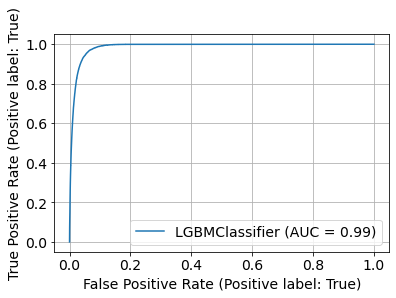

-------------------------------------------------------------
Training Precision-Recall Curve :


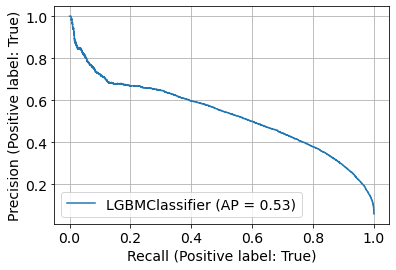

-------------------------------------------------------------


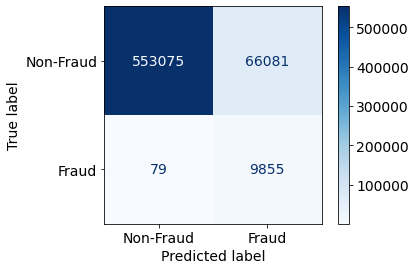

In [ ]:
train_model_results('LightGBM',lgbm_all_features,train_prepared,train_labels)

Testing Results for LightGBM

-------------------------------------------------------------
Testing Accuracy: 0.8818106095769777
Testing ROC AUC Score: 0.8200819412693701
Testing AP Score: 0.14884140192614562
-------------------------------------------------------------
Testing classification report :
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.89      0.94    154790
       Fraud       0.07      0.56      0.13      2483

    accuracy                           0.88    157273
   macro avg       0.53      0.72      0.53    157273
weighted avg       0.98      0.88      0.92    157273

-------------------------------------------------------------
Testing ROC Curve :


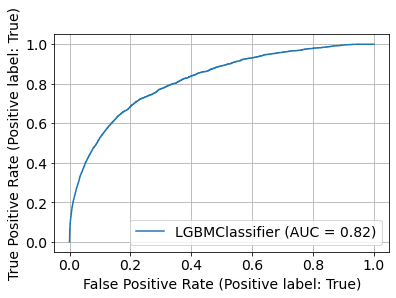

-------------------------------------------------------------
Testing Precision-Recall Curve :


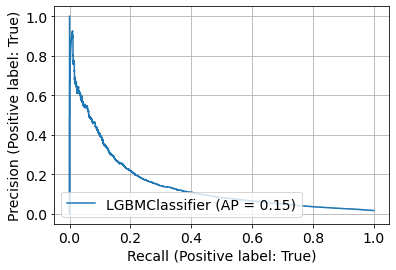

-------------------------------------------------------------


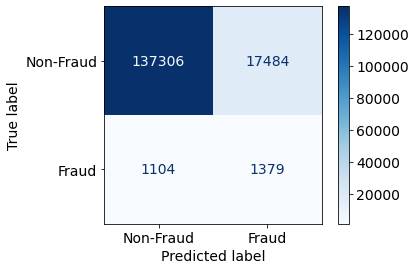

In [ ]:
test_model_results('LightGBM',lgbm_all_features,test_prepared)

In [ ]:
lgbm_all_features.importance_type

'split'

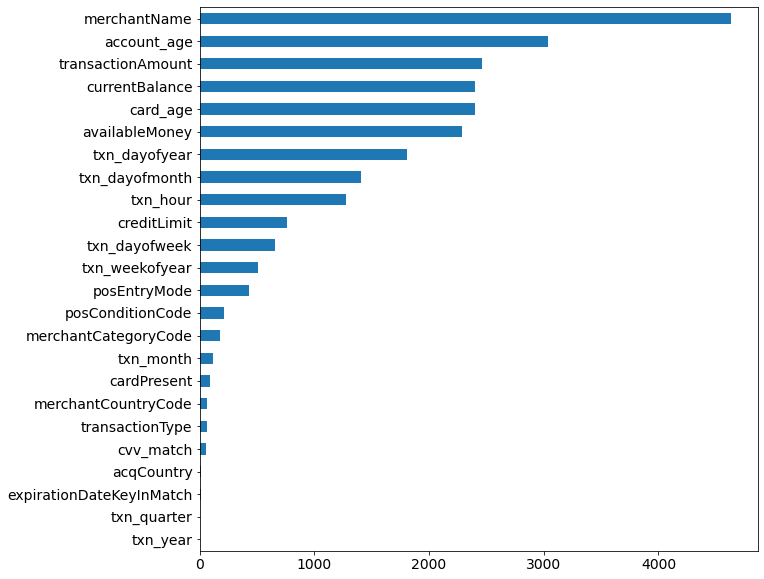

In [ ]:
feature_importance(lgbm_all_features)

## Training LGBM on Reduced Data

In [ ]:
#getting top 6 features
feature_importance = pd.Series(lgbm_all_features.feature_importances_, index = train_prepared_cols)
top6_features = feature_importance.sort_values(ascending = False)[:6].index.to_list()

In [ ]:
#reduced train data
train_prepared_new = train_prepared.loc[:,top6_features]
train_prepared_new_cols = train_prepared_new.columns.to_list()

In [ ]:
# # Extract categoricals and their indices
cat_features = train_prepared_new.select_dtypes(exclude=np.number).columns.to_list()
cat_idx = [train_prepared_new.columns.get_loc(col) for col in cat_features]

# Convert cat_features to pd.Categorical dtype
for col in cat_features:
    train_prepared_new[col] = pd.Categorical(train_prepared_new[col])

In [ ]:
#fitting lgbm on reduced data

start_time = time.time()

lgbm_cls_top6_features = lgb.LGBMClassifier(seed=42,**best_params)

lgbm_cls_top6_features.fit(train_prepared_new, train_labels)

print("elapsed time in seconds: ", time.time() - start_time) 

[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l1 is set=8.725743134669375e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.725743134669375e-06
[LightGBM] [Warning] bagging_fraction is set=0.9449837226694119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9449837226694119
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.9623161975060108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9623161975060108
elapsed time in seconds:  11.838111639022827


In [ ]:
# save model
joblib.dump(lgbm_cls_top6_features, 'lgbm_top6_features.pkl')

['lgbm_top6_features.pkl']

In [ ]:
# load model
lgbm_cls_top6_features = joblib.load('lgbm_top6_features.pkl')

Training Results for LightGBM

-------------------------------------------------------------
Training Accuracy: 0.8598324564052838
Training ROC AUC Score: 0.9763698554611505
Training AP Score: 0.42213271696392707
-------------------------------------------------------------
Training classification report :
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.86      0.92    619156
       Fraud       0.10      0.98      0.18      9934

    accuracy                           0.86    629090
   macro avg       0.55      0.92      0.55    629090
weighted avg       0.99      0.86      0.91    629090

-------------------------------------------------------------
Training ROC Curve :


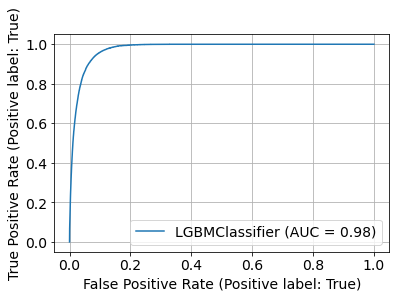

-------------------------------------------------------------
Training Precision-Recall Curve :


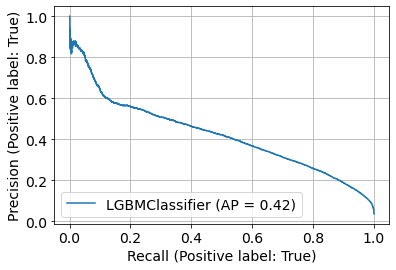

-------------------------------------------------------------


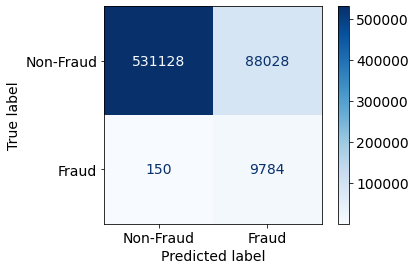

In [ ]:
train_model_results('LightGBM',lgbm_cls_top6_features,train_prepared_new,train_labels)

In [ ]:
test_prepared_new = test_prepared.loc[:,top6_features]

In [ ]:
# Convert cat_features to pd.Categorical dtype
for col in cat_features:
    test_prepared_new[col] = pd.Categorical(test_prepared_new[col])

Testing Results for LightGBM

-------------------------------------------------------------
Testing Accuracy: 0.8477297438212534
Testing ROC AUC Score: 0.7935782950655321
Testing AP Score: 0.13948026095661947
-------------------------------------------------------------
Testing classification report :
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.85      0.92    154790
       Fraud       0.06      0.55      0.10      2483

    accuracy                           0.85    157273
   macro avg       0.52      0.70      0.51    157273
weighted avg       0.98      0.85      0.90    157273

-------------------------------------------------------------
Testing ROC Curve :


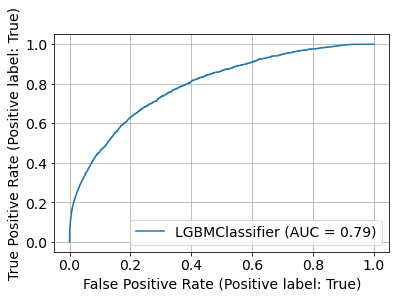

-------------------------------------------------------------
Testing Precision-Recall Curve :


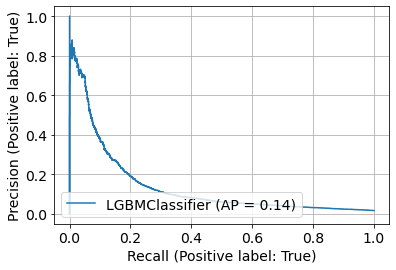

-------------------------------------------------------------


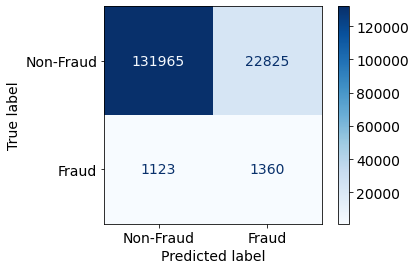

In [ ]:
test_model_results('LightGBM',lgbm_cls_top6_features,test_prepared_new)

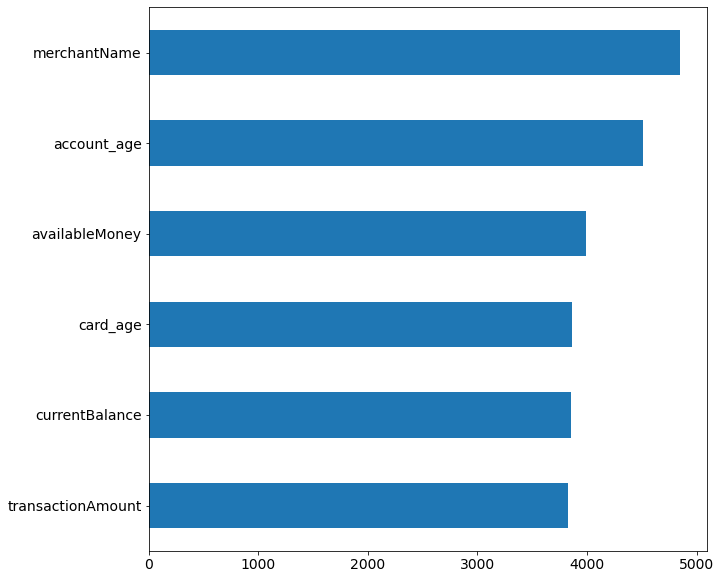

In [ ]:
feature_importance = pd.Series(lgbm_cls_top6_features.feature_importances_, index = train_prepared_new_cols)
plt.figure(figsize = (10,10))
feature_importance.sort_values().plot.barh()
plt.grid(False)
plt.show()

## Inference

In [ ]:
sample = pd.DataFrame([test_prepared_new.iloc[20].values],columns = train_prepared_new_cols)
sample['merchantName'] = pd.Categorical(sample['merchantName'])

In [ ]:
sample

,merchantName,account_age,transactionAmount,currentBalance,card_age,availableMoney
0,apple.com,747,337.78,1330.02,5996,13669.98


In [ ]:
#prepare new features and delete features no longer needed
cols_to_drop = ['transactionDateTime','currentExpDate','accountOpenDate']
cols_needed = ['merchantName', 'transactionAmount', 'currentBalance', 'availableMoney', 'transactionDateTime','accountOpenDate',
 'currentExpDate']
 
def prepare_data_for_inference(df):
  df = df.copy()
  df = df[cols_needed]
  df['card_age'] = (df['currentExpDate'] - df['accountOpenDate']).dt.days
  df['account_age'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days
  df['merchantName'] = df.merchantName.str.split('#').str[0].str.strip()
  df.drop(cols_to_drop,axis = 'columns',inplace = True)

  return df

In [ ]:
def model(model_file):
  classifier = joblib.load(model_file)
  return classifier

In [ ]:
# defining the function which will make the prediction using the data which the user inputs 
def prediction(merchantName, transactionAmount, currentBalance, availableMoney, transactionDate,accountOpenDate,
 currentExpDate):

    #dates
    txn_date = datetime.strptime(transactionDate,'%Y-%m-%d').date() 
    acc_open_date = datetime.strptime(accountOpenDate,'%Y-%m-%d').date()
    curr_exp_date = datetime.strptime(currentExpDate,'%Y-%m-%d').date()
 
    # Pre-processing user input
    card_age = abs(curr_exp_date - acc_open_date).days
    account_age = abs(txn_date - acc_open_date).days

    data = {'merchantName':[merchantName],'account_age':[account_age],'transactionAmount':[transactionAmount],
            'card_age':[card_age],'currentBalance':[currentBalance],'availableMoney':[availableMoney]}

    sample = pd.DataFrame(data)

    sample['merchantName'] = pd.Categorical(sample['merchantName'])

    #classifier
    classifier = model(model_file)

    # Making predictions 
    prediction = classifier.predict(sample)[0]
     
    if prediction == True:
        pred = 'Fraud'
    else:
        pred = 'Not Fraud'
    return pred

In [ ]:
model_file = "./lgbm_top6_features.pkl"

In [ ]:
prediction('apple.com',337.78,1330.02,13669.98,'2016-01-17','2013-12-31','2030-06-01')

'Fraud'